# 직접 만들어 보는 OCR

## 들어가며
이번 시간에는 OCR을 직접 만들어보는 시간을 갖도록 하겠습니다. OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하고 Recognition을 직접 만들고 학습해보도록 하겠습니다.

## 실습목표
- Text Recognition 모델을 직접 구현해 봅니다.
- Text Recognition 모델 학습을 진행해 봅니다.
- Text Detection 모델과 연결하여 전체 OCR 시스템을 구현합니다.

## 목차
- Overall sturcture of OCR
- SynthText
- Recognition model
- End-to-End OCR


# 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

- 평가문항	상세기준
    1. [데이터셋관련] 학습 데이터셋을 효과적으로 전처리했는가? : OCR Dataset을 데이터를 정확히 로드했는가? Label Encoder를 정확하게 만들었는가? 이미지 처리 방법을 이해 했는가?
    2. [트레이닝 기법 관련] 학습을 위한 파라미터는 적절했는가? : GPU 메모리를 고려한 배치사이즈 설정, 배치사이즈에 따른 step크기 설정, 적절한 epoch 설정
    3. [정량적 수행결과 관련] 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? : Recognition model의 inference가 성공적으로 동작하는가? Detection 모델의 inference결과를 눈으로 확인하였는가? Recognition 모델의 inference결과를 눈으로 확인하였는가?

# Dataset for OCR 준비하기

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr_recognition_model')
os.chdir(path)

# Recognition model (1)
- 영문 대문자와 숫자를 인식하기 위해서는 몇가지의 Class가 필요할까요?

    - 총 36가지가 필요합니다. 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다.

In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


- lmdb 설치하기
    - LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자
    - 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있음

- \$ pip install lmdb
- 필요한 라이브러리들을 import하고, 다운로드한 MJ 데이터셋의 위치 옮기기

In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr_recognition_model'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

In [5]:
TRAIN_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_train'

In [6]:
VALID_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_valid'

In [7]:
TEST_DATA_PATH

'/home/aiffel0042/aiffel/ocr_recognition_model/MJ/MJ_test'

# Recognition model (2) Input Image
- 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 본다.
    - lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 본다.



original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


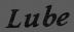

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


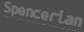

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


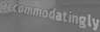

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


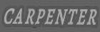

In [8]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- 대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양하다.

- lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현한다. 
- label_converter는 문자를 미리정의된 index로 변환해주는 converter로 직접 구현한다.
- batch_size와 입력이미지 크기, 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있다.

In [9]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

- 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영됨
- model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴하게 됨
- _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있다.

# Recognition model (3) Encode
- LabelConverter 클래스를 작성해봅시다.
    - Label은 우리가 읽을 수 있는 평문 Text로 이루어져 있는데, 이는 모델을 학습하기 위해서 적절한 형태가 아니므로, 
    - 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해준다.

- __init__() 에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장한다. 
    - 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다. 

- decode는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어준다.

- encode를 모델이 학습할 수 있는 label로 만들어 준다.

In [10]:
class LabelConverter(object):
    """ Convert between text-label and text-index """
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

- 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해본다.

In [11]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# Recognition model (4) Build CRNN model
- 입력과 출력을 준비했으니 모델을 만들어볼 차례이다.
- Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func을 만들어준다. 

In [12]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

- 여기서 잠시 Keras의 K.ctc\_batch\_cost() 함수에 대해 짚고 넘어갑시다. 비록 우리가 이 함수 내부를 직접 구현하진 않겠지만 CTC Loss 함수를 구현하기 위해 우리가 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해야 합니다.

![title](./images/ctc.png)

- 우리는 CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고 있습니다. 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 그래서 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있습니다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됩니다.

- 위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

    - y_true: tensor (samples, max_string_length) containing the truth labels.
    - y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
    - input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
    - label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.
    - (여기서 samples는 배치사이즈를 의미합니다.)

![title](./images/GC-6-P-example.png)

- 위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시입니다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것입니다.

    - y_true: 실제 라벨 LUBE. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
    - y_pred: 우리가 만들 RCNN 모델의 출력 결과. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
    - input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
    - label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4

- 이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.


In [39]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS, gru=False):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    
    if gru:
        sequnce = layers.Bidirectional(layers.GRU(256, return_sequences=True))(sequnce)
        sequnce = layers.Bidirectional(layers.GRU(256, return_sequences=True))(sequnce)        
    else:
        sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
        sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

# Recognition model (5) Train & Inference
- 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜본다.

## (1) RNN부분에서 LSTM 모델로 학습해 본다

In [15]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

LSTM_checkpoint_path = HOME_DIR + '/models/LSTM_model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    LSTM_checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
history = model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=300,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/300
63/63 [==============================] - ETA: 0s - loss: 29.2822
Epoch 00001: val_loss improved from inf to 27.11917, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 9s 141ms/step - loss: 29.2822 - val_loss: 27.1192
Epoch 2/300
63/63 [==============================] - ETA: 0s - loss: 26.6689
Epoch 00002: val_loss improved from 27.11917 to 26.21005, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 133ms/step - loss: 26.6689 - val_loss: 26.2100
Epoch 3/300
63/63 [==============================] - ETA: 0s - loss: 26.0721
Epoch 00003: val_loss improved from 26.21005 to 26.04642, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 26.0721 - val_loss: 26.0464
Epoch 4/300
63/63 [====================

Epoch 28/300
63/63 [==============================] - ETA: 0s - loss: 5.8548
Epoch 00028: val_loss improved from 6.40029 to 5.99174, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 5.8548 - val_loss: 5.9917
Epoch 29/300
63/63 [==============================] - ETA: 0s - loss: 5.9339
Epoch 00029: val_loss did not improve from 5.99174
63/63 [==============================] - 8s 125ms/step - loss: 5.9339 - val_loss: 6.0149
Epoch 30/300
63/63 [==============================] - ETA: 0s - loss: 5.6995
Epoch 00030: val_loss improved from 5.99174 to 5.66691, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 5.6995 - val_loss: 5.6669
Epoch 31/300
63/63 [==============================] - ETA: 0s - loss: 5.7100
Epoch 00031: val_loss did not improve from 5.66691
63/63 [============

Epoch 58/300
63/63 [==============================] - ETA: 0s - loss: 3.5368
Epoch 00058: val_loss did not improve from 3.81390
63/63 [==============================] - 8s 127ms/step - loss: 3.5368 - val_loss: 3.9322
Epoch 59/300
63/63 [==============================] - ETA: 0s - loss: 3.5679
Epoch 00059: val_loss improved from 3.81390 to 3.76919, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 3.5679 - val_loss: 3.7692
Epoch 60/300
63/63 [==============================] - ETA: 0s - loss: 3.5280
Epoch 00060: val_loss improved from 3.76919 to 3.67774, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 3.5280 - val_loss: 3.6777
Epoch 61/300
63/63 [==============================] - ETA: 0s - loss: 3.5317
Epoch 00061: val_loss did not improve from 3.67774
63/63 [============

Epoch 89/300
63/63 [==============================] - ETA: 0s - loss: 2.7828
Epoch 00089: val_loss did not improve from 2.98923
63/63 [==============================] - 8s 126ms/step - loss: 2.7828 - val_loss: 3.0409
Epoch 90/300
63/63 [==============================] - ETA: 0s - loss: 2.9045
Epoch 00090: val_loss did not improve from 2.98923
63/63 [==============================] - 8s 126ms/step - loss: 2.9045 - val_loss: 3.0412
Epoch 91/300
63/63 [==============================] - ETA: 0s - loss: 2.8675
Epoch 00091: val_loss did not improve from 2.98923
63/63 [==============================] - 8s 124ms/step - loss: 2.8675 - val_loss: 3.1242
Epoch 92/300
63/63 [==============================] - ETA: 0s - loss: 2.9253
Epoch 00092: val_loss improved from 2.98923 to 2.98045, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 2.9253 - val_loss: 2.9805
Epoch 93/300
63/63 [===========

Epoch 122/300
63/63 [==============================] - ETA: 0s - loss: 2.5066
Epoch 00122: val_loss did not improve from 2.56738
63/63 [==============================] - 8s 125ms/step - loss: 2.5066 - val_loss: 2.7406
Epoch 123/300
63/63 [==============================] - ETA: 0s - loss: 2.4843
Epoch 00123: val_loss did not improve from 2.56738
63/63 [==============================] - 8s 125ms/step - loss: 2.4843 - val_loss: 2.6381
Epoch 124/300
63/63 [==============================] - ETA: 0s - loss: 2.5494
Epoch 00124: val_loss did not improve from 2.56738
63/63 [==============================] - 8s 124ms/step - loss: 2.5494 - val_loss: 2.6964
Epoch 125/300
63/63 [==============================] - ETA: 0s - loss: 2.5394
Epoch 00125: val_loss improved from 2.56738 to 2.53170, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 2.5394 - val_loss: 2.5317
Epoch 126/300
63/63 [======

Epoch 156/300
63/63 [==============================] - ETA: 0s - loss: 2.2705
Epoch 00156: val_loss improved from 2.30903 to 2.28780, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 2.2705 - val_loss: 2.2878
Epoch 157/300
63/63 [==============================] - ETA: 0s - loss: 2.2378
Epoch 00157: val_loss did not improve from 2.28780
63/63 [==============================] - 8s 125ms/step - loss: 2.2378 - val_loss: 2.4274
Epoch 158/300
63/63 [==============================] - ETA: 0s - loss: 2.2462
Epoch 00158: val_loss did not improve from 2.28780
63/63 [==============================] - 8s 125ms/step - loss: 2.2462 - val_loss: 2.4011
Epoch 159/300
63/63 [==============================] - ETA: 0s - loss: 2.3199
Epoch 00159: val_loss did not improve from 2.28780
63/63 [==============================] - 8s 124ms/step - loss: 2.3199 - val_loss: 2.3588
Epoch 160/300
63/63 [======

Epoch 190/300
63/63 [==============================] - ETA: 0s - loss: 1.9958
Epoch 00190: val_loss did not improve from 2.10054
63/63 [==============================] - 8s 124ms/step - loss: 1.9958 - val_loss: 2.1416
Epoch 191/300
63/63 [==============================] - ETA: 0s - loss: 1.9210
Epoch 00191: val_loss did not improve from 2.10054
63/63 [==============================] - 8s 125ms/step - loss: 1.9210 - val_loss: 2.1545
Epoch 192/300
63/63 [==============================] - ETA: 0s - loss: 1.9709
Epoch 00192: val_loss did not improve from 2.10054
63/63 [==============================] - 8s 125ms/step - loss: 1.9709 - val_loss: 2.1293
Epoch 193/300
63/63 [==============================] - ETA: 0s - loss: 2.0371
Epoch 00193: val_loss improved from 2.10054 to 2.07674, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 2.0371 - val_loss: 2.0767
Epoch 194/300
63/63 [======

Epoch 223/300
63/63 [==============================] - ETA: 0s - loss: 1.8848
Epoch 00223: val_loss did not improve from 1.94424
63/63 [==============================] - 8s 125ms/step - loss: 1.8848 - val_loss: 1.9880
Epoch 224/300
63/63 [==============================] - ETA: 0s - loss: 1.9989
Epoch 00224: val_loss did not improve from 1.94424
63/63 [==============================] - 8s 125ms/step - loss: 1.9989 - val_loss: 1.9557
Epoch 225/300
63/63 [==============================] - ETA: 0s - loss: 1.9074
Epoch 00225: val_loss improved from 1.94424 to 1.92614, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 1.9074 - val_loss: 1.9261
Epoch 226/300
63/63 [==============================] - ETA: 0s - loss: 1.9570
Epoch 00226: val_loss did not improve from 1.92614
63/63 [==============================] - 8s 125ms/step - loss: 1.9570 - val_loss: 1.9876
Epoch 227/300
63/63 [======

Epoch 257/300
63/63 [==============================] - ETA: 0s - loss: 1.7455
Epoch 00257: val_loss did not improve from 1.84102
63/63 [==============================] - 7s 119ms/step - loss: 1.7455 - val_loss: 1.8605
Epoch 258/300
63/63 [==============================] - ETA: 0s - loss: 1.7768
Epoch 00258: val_loss did not improve from 1.84102
63/63 [==============================] - 8s 123ms/step - loss: 1.7768 - val_loss: 1.9484
Epoch 259/300
63/63 [==============================] - ETA: 0s - loss: 1.7073
Epoch 00259: val_loss did not improve from 1.84102
63/63 [==============================] - 8s 119ms/step - loss: 1.7073 - val_loss: 1.8469
Epoch 260/300
63/63 [==============================] - ETA: 0s - loss: 1.7795
Epoch 00260: val_loss did not improve from 1.84102
63/63 [==============================] - 7s 119ms/step - loss: 1.7795 - val_loss: 1.8834
Epoch 261/300
63/63 [==============================] - ETA: 0s - loss: 1.8062
Epoch 00261: val_loss did not improve from 1.84102

Epoch 292/300
63/63 [==============================] - ETA: 0s - loss: 1.6968
Epoch 00292: val_loss improved from 1.76776 to 1.76042, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 1.6968 - val_loss: 1.7604
Epoch 293/300
63/63 [==============================] - ETA: 0s - loss: 1.6231
Epoch 00293: val_loss improved from 1.76042 to 1.74724, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 1.6231 - val_loss: 1.7472
Epoch 294/300
63/63 [==============================] - ETA: 0s - loss: 1.7448
Epoch 00294: val_loss improved from 1.74724 to 1.74484, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/LSTM_model_checkpoint.hdf5
63/63 [==============================] - 8s 128ms/step - loss: 1.7448 - val_loss: 1.7448
Epoch 295/300
63/63 [======================

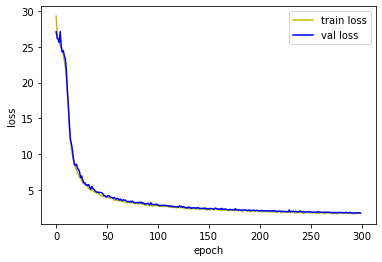

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'b', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')
plt.savefig('./images/LSTM_crnn_result.png')
plt.show()

## LSTM 모델을 Testset으로 inference해보고 이를 확인해 보기

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Result: 	 SLINKING9999999999999999


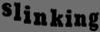

Result: 	 ALEPPO99999999999999999


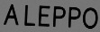

Result: 	 RWANDA999999999999999999


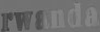

Result: 	 NATHANS99999999999999999


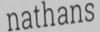

Result: 	 HALLO999999999999999999


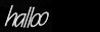

Result: 	 HURLS9999999999999999999


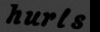

Result: 	 DOWNSIZE9999999999999999


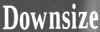

Result: 	 ROBOTIC99999999999999999


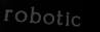

Result: 	 SLOPPY99999999999999999


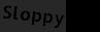

Result: 	 HERMITE99999999999999999


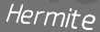

In [21]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(LSTM_checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## (2) RNN부분에서 GRU 모델로 학습해 본다

In [40]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

GRU_checkpoint_path = HOME_DIR + '/models/GRU_model_checkpoint.hdf5'

model1, y_func1 = build_crnn_model(gru=True)
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model1.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    GRU_checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
history1 = model1.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=300,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/300
63/63 [==============================] - ETA: 0s - loss: 29.4719
Epoch 00001: val_loss improved from inf to 27.02435, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 130ms/step - loss: 29.4719 - val_loss: 27.0243
Epoch 2/300
63/63 [==============================] - ETA: 0s - loss: 26.6140
Epoch 00002: val_loss did not improve from 27.02435
63/63 [==============================] - 8s 121ms/step - loss: 26.6140 - val_loss: 27.0617
Epoch 3/300
63/63 [==============================] - ETA: 0s - loss: 26.1745
Epoch 00003: val_loss did not improve from 27.02435
63/63 [==============================] - 7s 118ms/step - loss: 26.1745 - val_loss: 27.1551
Epoch 4/300
63/63 [==============================] - ETA: 0s - loss: 25.7281
Epoch 00004: val_loss improved from 27.02435 to 26.57393, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [=======

Epoch 30/300
63/63 [==============================] - ETA: 0s - loss: 5.2392
Epoch 00030: val_loss did not improve from 5.58522
63/63 [==============================] - 8s 124ms/step - loss: 5.2392 - val_loss: 5.5877
Epoch 31/300
63/63 [==============================] - ETA: 0s - loss: 5.3104
Epoch 00031: val_loss improved from 5.58522 to 5.41521, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 124ms/step - loss: 5.3104 - val_loss: 5.4152
Epoch 32/300
63/63 [==============================] - ETA: 0s - loss: 5.0430
Epoch 00032: val_loss improved from 5.41521 to 5.39563, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 5.0430 - val_loss: 5.3956
Epoch 33/300
63/63 [==============================] - ETA: 0s - loss: 4.8978
Epoch 00033: val_loss improved from 5.39563 to 5.12685, saving model to 

Epoch 60/300
63/63 [==============================] - ETA: 0s - loss: 3.4902
Epoch 00060: val_loss improved from 3.70405 to 3.67429, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 120ms/step - loss: 3.4902 - val_loss: 3.6743
Epoch 61/300
63/63 [==============================] - ETA: 0s - loss: 3.5863
Epoch 00061: val_loss did not improve from 3.67429
63/63 [==============================] - 8s 120ms/step - loss: 3.5863 - val_loss: 3.8069
Epoch 62/300
63/63 [==============================] - ETA: 0s - loss: 3.4813
Epoch 00062: val_loss did not improve from 3.67429
63/63 [==============================] - 7s 119ms/step - loss: 3.4813 - val_loss: 3.7434
Epoch 63/300
63/63 [==============================] - ETA: 0s - loss: 3.5182
Epoch 00063: val_loss improved from 3.67429 to 3.62958, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============

Epoch 92/300
63/63 [==============================] - ETA: 0s - loss: 2.8377
Epoch 00092: val_loss did not improve from 2.92441
63/63 [==============================] - 8s 123ms/step - loss: 2.8377 - val_loss: 2.9458
Epoch 93/300
63/63 [==============================] - ETA: 0s - loss: 2.8695
Epoch 00093: val_loss did not improve from 2.92441
63/63 [==============================] - 8s 123ms/step - loss: 2.8695 - val_loss: 3.2478
Epoch 94/300
63/63 [==============================] - ETA: 0s - loss: 2.7576
Epoch 00094: val_loss improved from 2.92441 to 2.88834, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 2.7576 - val_loss: 2.8883
Epoch 95/300
63/63 [==============================] - ETA: 0s - loss: 2.7639
Epoch 00095: val_loss did not improve from 2.88834
63/63 [==============================] - 8s 124ms/step - loss: 2.7639 - val_loss: 2.9208
Epoch 96/300
63/63 [============

63/63 [==============================] - ETA: 0s - loss: 2.3925
Epoch 00125: val_loss improved from 2.57369 to 2.55355, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 2.3925 - val_loss: 2.5536
Epoch 126/300
63/63 [==============================] - ETA: 0s - loss: 2.4100
Epoch 00126: val_loss improved from 2.55355 to 2.53129, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 2.4100 - val_loss: 2.5313
Epoch 127/300
63/63 [==============================] - ETA: 0s - loss: 2.4927
Epoch 00127: val_loss did not improve from 2.53129
63/63 [==============================] - 8s 124ms/step - loss: 2.4927 - val_loss: 2.6096
Epoch 128/300
63/63 [==============================] - ETA: 0s - loss: 2.3302
Epoch 00128: val_loss did not improve from 2.53129
63/63 [========================

Epoch 159/300
63/63 [==============================] - ETA: 0s - loss: 2.1111
Epoch 00159: val_loss did not improve from 2.29963
63/63 [==============================] - 8s 124ms/step - loss: 2.1111 - val_loss: 2.3297
Epoch 160/300
63/63 [==============================] - ETA: 0s - loss: 2.2859
Epoch 00160: val_loss did not improve from 2.29963
63/63 [==============================] - 7s 117ms/step - loss: 2.2859 - val_loss: 2.3079
Epoch 161/300
63/63 [==============================] - ETA: 0s - loss: 2.1962
Epoch 00161: val_loss improved from 2.29963 to 2.27218, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 7s 118ms/step - loss: 2.1962 - val_loss: 2.2722
Epoch 162/300
63/63 [==============================] - ETA: 0s - loss: 2.2058
Epoch 00162: val_loss did not improve from 2.27218
63/63 [==============================] - 7s 116ms/step - loss: 2.2058 - val_loss: 2.2827
Epoch 163/300
63/63 [=======

63/63 [==============================] - ETA: 0s - loss: 2.0258
Epoch 00190: val_loss did not improve from 2.11003
63/63 [==============================] - 7s 116ms/step - loss: 2.0258 - val_loss: 2.2041
Epoch 191/300
63/63 [==============================] - ETA: 0s - loss: 2.1268
Epoch 00191: val_loss improved from 2.11003 to 2.08753, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 7s 119ms/step - loss: 2.1268 - val_loss: 2.0875
Epoch 192/300
63/63 [==============================] - ETA: 0s - loss: 2.0330
Epoch 00192: val_loss did not improve from 2.08753
63/63 [==============================] - 7s 117ms/step - loss: 2.0330 - val_loss: 2.0893
Epoch 193/300
63/63 [==============================] - ETA: 0s - loss: 1.9588
Epoch 00193: val_loss did not improve from 2.08753
63/63 [==============================] - 8s 120ms/step - loss: 1.9588 - val_loss: 2.1112
Epoch 194/300
63/63 [=====================

Epoch 224/300
63/63 [==============================] - ETA: 0s - loss: 1.8114
Epoch 00224: val_loss improved from 1.94959 to 1.93646, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 120ms/step - loss: 1.8114 - val_loss: 1.9365
Epoch 225/300
63/63 [==============================] - ETA: 0s - loss: 1.8261
Epoch 00225: val_loss did not improve from 1.93646
63/63 [==============================] - 8s 119ms/step - loss: 1.8261 - val_loss: 1.9662
Epoch 226/300
63/63 [==============================] - ETA: 0s - loss: 1.8553
Epoch 00226: val_loss did not improve from 1.93646
63/63 [==============================] - 8s 123ms/step - loss: 1.8553 - val_loss: 1.9741
Epoch 227/300
63/63 [==============================] - ETA: 0s - loss: 1.8349
Epoch 00227: val_loss did not improve from 1.93646
63/63 [==============================] - 8s 121ms/step - loss: 1.8349 - val_loss: 1.9490
Epoch 228/300
63/63 [=======

Epoch 257/300
63/63 [==============================] - ETA: 0s - loss: 1.8197
Epoch 00257: val_loss did not improve from 1.81434
63/63 [==============================] - 8s 125ms/step - loss: 1.8197 - val_loss: 1.8871
Epoch 258/300
63/63 [==============================] - ETA: 0s - loss: 1.8551
Epoch 00258: val_loss did not improve from 1.81434
63/63 [==============================] - 7s 118ms/step - loss: 1.8551 - val_loss: 1.8724
Epoch 259/300
63/63 [==============================] - ETA: 0s - loss: 1.8419
Epoch 00259: val_loss did not improve from 1.81434
63/63 [==============================] - 8s 120ms/step - loss: 1.8419 - val_loss: 1.9244
Epoch 260/300
63/63 [==============================] - ETA: 0s - loss: 1.7763
Epoch 00260: val_loss did not improve from 1.81434
63/63 [==============================] - 8s 123ms/step - loss: 1.7763 - val_loss: 1.8328
Epoch 261/300
63/63 [==============================] - ETA: 0s - loss: 1.7698
Epoch 00261: val_loss did not improve from 1.81434

63/63 [==============================] - ETA: 0s - loss: 1.6726
Epoch 00291: val_loss improved from 1.72958 to 1.72477, saving model to /home/aiffel0042/aiffel/ocr_recognition_model/models/GRU_model_checkpoint.hdf5
63/63 [==============================] - 8s 125ms/step - loss: 1.6726 - val_loss: 1.7248
Epoch 292/300
63/63 [==============================] - ETA: 0s - loss: 1.6504
Epoch 00292: val_loss did not improve from 1.72477
63/63 [==============================] - 8s 124ms/step - loss: 1.6504 - val_loss: 1.7659
Epoch 293/300
63/63 [==============================] - ETA: 0s - loss: 1.7058
Epoch 00293: val_loss did not improve from 1.72477
63/63 [==============================] - 8s 124ms/step - loss: 1.7058 - val_loss: 1.7509
Epoch 294/300
63/63 [==============================] - ETA: 0s - loss: 1.5925
Epoch 00294: val_loss did not improve from 1.72477
63/63 [==============================] - 8s 123ms/step - loss: 1.5925 - val_loss: 1.7571
Epoch 295/300
63/63 [=====================

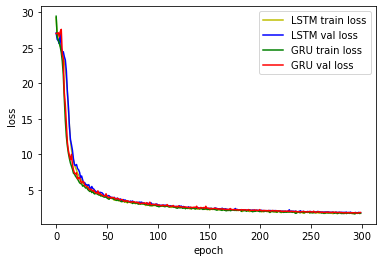

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='LSTM train loss')
loss_ax.plot(history.history['val_loss'], 'b', label='LSTM val loss')

loss_ax.plot(history1.history['loss'], 'g', label='GRU train loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='GRU val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.savefig('./images/GRU_crnn_result.png')
plt.show()

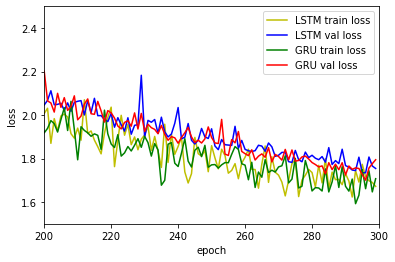

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='LSTM train loss')
loss_ax.plot(history.history['val_loss'], 'b', label='LSTM val loss')

loss_ax.plot(history1.history['loss'], 'g', label='GRU train loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='GRU val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

loss_ax.axis([200, 300, 1.5, 2.5])

plt.savefig('./images/LSTM_GRU_crnn_result.png')
plt.show()

## GRU 모델을 Testset으로 inference해보고 이를 확인해 보기

Result: 	 SLINKING9999999999999999


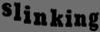

Result: 	 ALEPPO99999999999999999


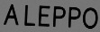

Result: 	 TWANDA999999999999999999


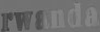

Result: 	 NATHANS99999999999999999


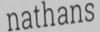

Result: 	 HALLO999999999999999999


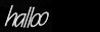

Result: 	 HURLS9999999999999999999


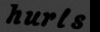

Result: 	 DOWNSIZE9999999999999999


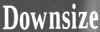

Result: 	 ROBOTIC99999999999999999


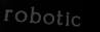

Result: 	 SLOPPY99999999999999999


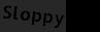

Result: 	 HERMITE99999999999999999


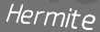

In [45]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model1, y_func1 = build_crnn_model(gru=True)

model1.load_weights(GRU_checkpoint_path)
input_data = model1.get_layer('input_image').output
y_pred1 = model1.get_layer('output').output
model_pred1 = Model(inputs=input_data, outputs=y_pred1)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred1.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model1, test_set, index=10)

# 프로젝트: End-to-End OCR

- keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요. 위의 사진 sample.jpg도 ocr폴더에 다운받으셔야합니다.



# (1) RNN부분에서 LSTM 모델로 학습한 결과

In [58]:
from keras_ocr.detection import Detector
from PIL import ImageDraw, Image
SAMPLE_IMG_PATH = './images/sample1.jpg'
detector = Detector()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


- 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 그리고 단어의 영역을 잘라오도록 해주세요.

In [59]:
# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]

In [60]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다. 
    detect_result = detector.detect(img.numpy())

    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detect_result[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw = ImageDraw.Draw(img_pil)
    result_img = img_pil
        
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

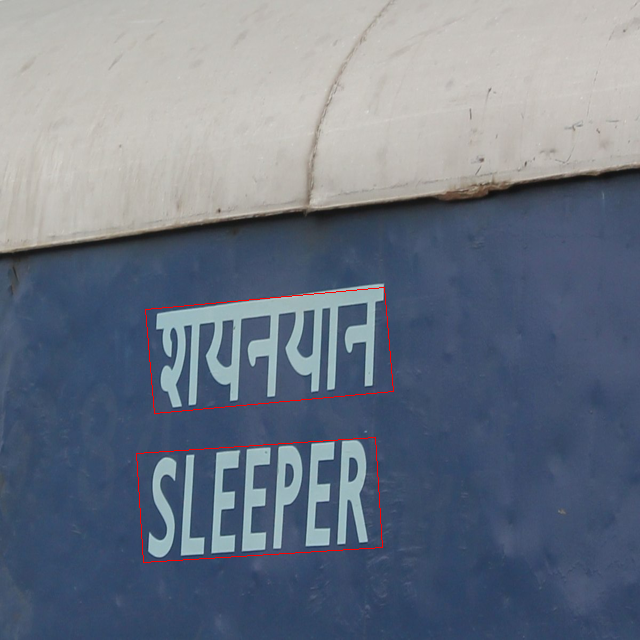

In [61]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

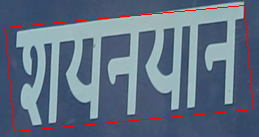

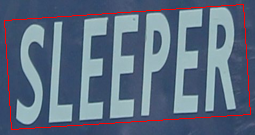

In [62]:
for sub_img in cropped_img:
    display(sub_img)

- 이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

In [63]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 ERTARINS9999999999999999


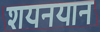

Result: 	 SLEEPERE999999999999999


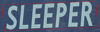

In [64]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


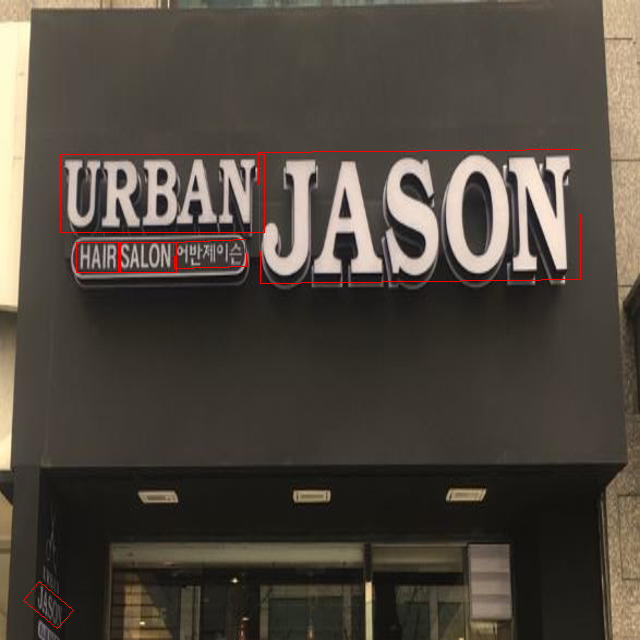

In [65]:
SAMPLE_IMG_PATH = './images/sample2.jpg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

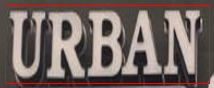

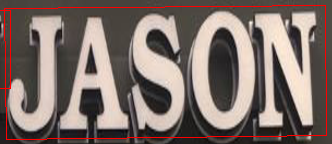

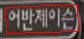

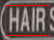

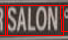

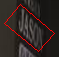

In [66]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 URBANS999999999999999999


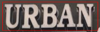

Result: 	 JASON9999999999999999999


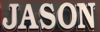

Result: 	 CPADS9999999999999999999


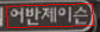

Result: 	 EHARE9999999999999999999


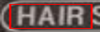

Result: 	 ESALONE99999999999999999


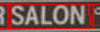

Result: 	 NS9999999999999999999999


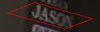

In [67]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


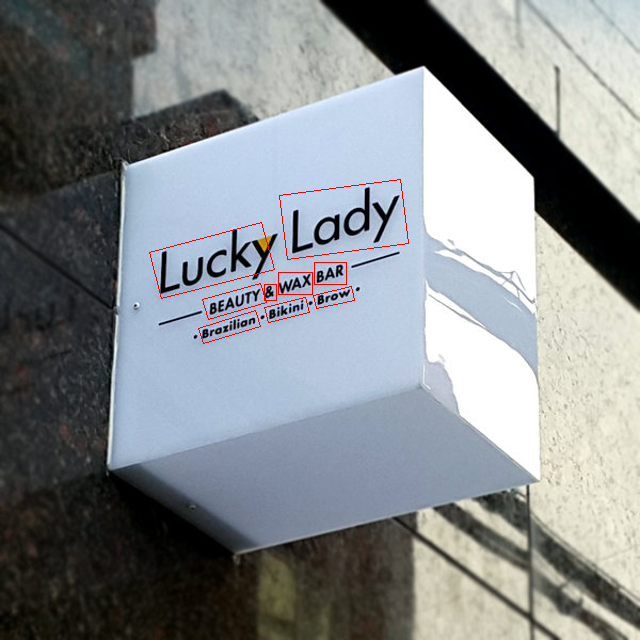

In [68]:
SAMPLE_IMG_PATH = './images/sample3.jpeg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

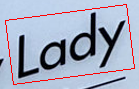

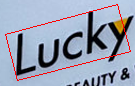

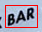

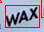

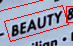

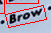

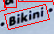

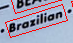

In [71]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 FLADY9999999999999999999


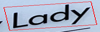

Result: 	 LUCKT9999999999999999999


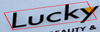

Result: 	 BARE99999999999999999999


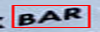

Result: 	 AE9999999999999999999999


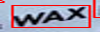

Result: 	 DES999999999999999999999


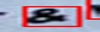

Result: 	 RBEAUNS99999999999999999


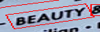

Result: 	 RENOI9999999999999999999


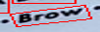

Result: 	 CING99999999999999999999


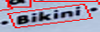

Result: 	 PERAIANS9999999999999999


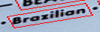

In [70]:
for _img in cropped_img:
    recognize_img(_img)

# (2) RNN부분에서 GRU 모델로 학습한 결과

In [46]:
SAMPLE_IMG_PATH = './images/sample1.jpg'
detector = Detector()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


In [47]:
# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]

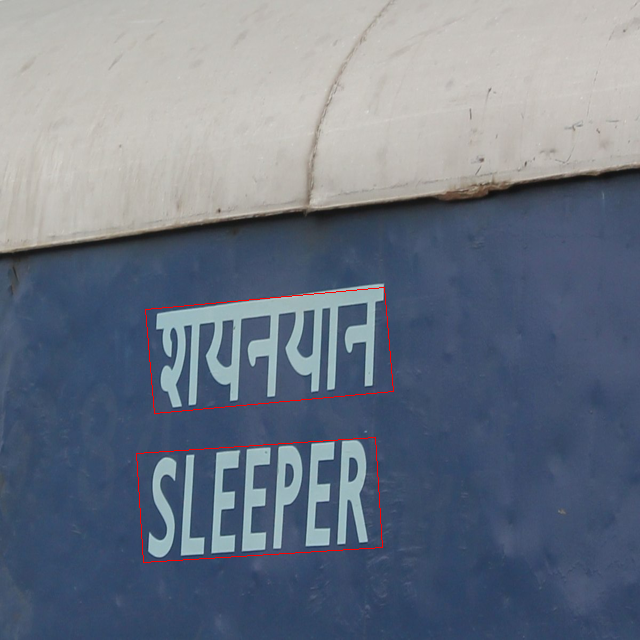

In [48]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

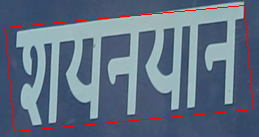

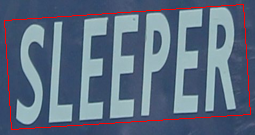

In [49]:
for sub_img in cropped_img:
    display(sub_img)

In [50]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred1.predict(np_img)
    
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 PRS999999999999999999999


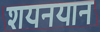

Result: 	 SLEEPERS999999999999999


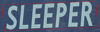

In [51]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


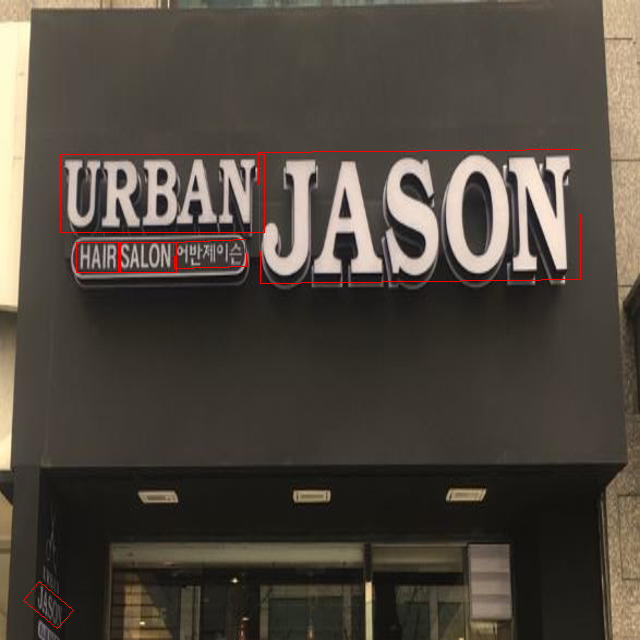

In [52]:
SAMPLE_IMG_PATH = './images/sample2.jpg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

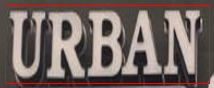

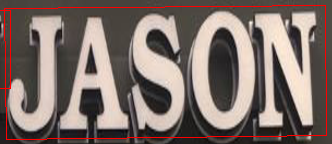

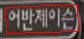

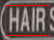

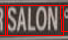

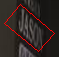

In [53]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 URBAN9999999999999999999


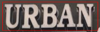

Result: 	 JASON9999999999999999999


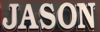

Result: 	 TRAIES999999999999999999


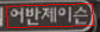

Result: 	 CIHARE99999999999999999


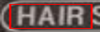

Result: 	 JDISALIONTS9999999999999


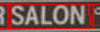

Result: 	 SATRESI99999999999999999


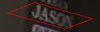

In [54]:
for _img in cropped_img:
    recognize_img(_img)

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


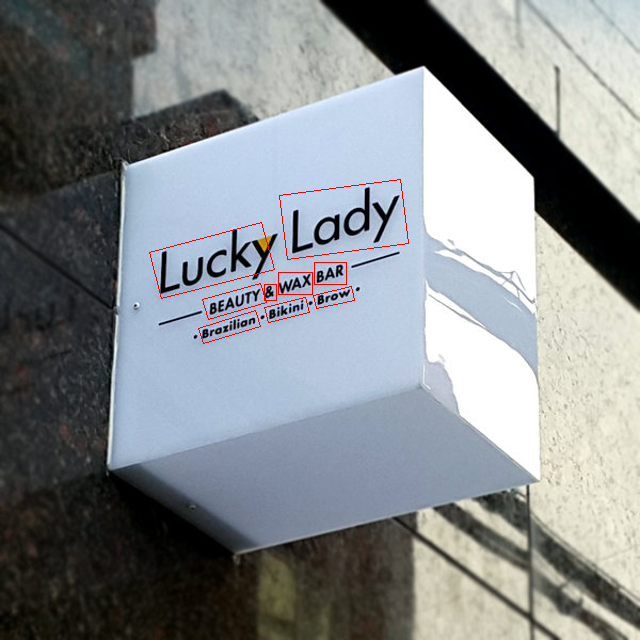

In [55]:
SAMPLE_IMG_PATH = './images/sample3.jpeg'
detector = Detector()

# 입력이미지를 불러오기
img = tf.io.read_file(SAMPLE_IMG_PATH)
img = tf.image.decode_jpeg(img)
img = tf.image.resize(img, (640, 640))
img = img[tf.newaxis, :, :, :]
detect_result = detector.detect(img.numpy())

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

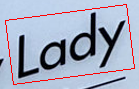

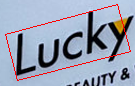

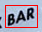

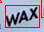

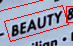

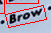

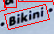

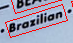

In [56]:
for sub_img in cropped_img:
    display(sub_img)

Result: 	 LADS99999999999999999999


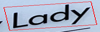

Result: 	 LUCKY9999999999999999999


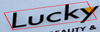

Result: 	 CEA999999999999999999999


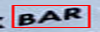

Result: 	 WMASIY999999999999999999


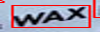

Result: 	 CAEINS999999999999999999


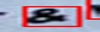

Result: 	 REAUME999999999999999999


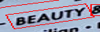

Result: 	 EREY99999999999999999999


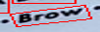

Result: 	 ERKINTR99999999999999999


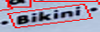

Result: 	 PERCAENY9999999999999999


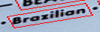

In [57]:
for _img in cropped_img:
    recognize_img(_img)

# 결론
- 영어에 대한 인식율은 높지만, 한국어나 아랍어 등 다른 나라의 언어에 대한 인식율을 낮았다. 
- 프로젝트에서 주어진 Sample 이미지 외에 추가적으로 2개를 더 돌려서 결과를 비교 분석해 보았다. 

## (1) RNN부분에서 LSTM 모델로 학습한 결과

- 300 epochs으로 학습 시켜서 validation loss를 1.73483까지 줄였다. (200 epochs = 2.06073, 100 epochs = 2.88273)

![title](./images/LSTM_crnn_result.png)

## (2) RNN부분에서 GRU 모델로 학습한 결과

- 300 epochs으로 학습 시켜서 validation loss를 1.70062까지 줄였다. (200 epochs = 2.06909, 100 epochs = 2.84003)

![title](./images/GRU_crnn_result.png)


## 결론적으로 GRU 모델이 성능이 약간 더 좋았다. 

![title](./images/LSTM_GRU_crnn_result.png)


## 첫번째 샘플 이미지

![title](./images/sample1.jpg)

![title](./images/sample_result1.png)

### (1) RNN부분 LSTM 학습 결과

![title](./images/LSTM_sample1.png)

### (2) RNN부분 GRU 학습 결과

![title](./images/GRU_sample1.png)

- 단어간의 간격이 충분이 멀기 때문에, 각 단어의 위치를 잘 찾아내었다.
- 아랍어는 인식하지 못했으나, 영어는 마지막 글자를 하나 덧붙인 것 SLEEPER***E***(LSTM), SLEEPER***S***(GRU) 빼고는 잘 인식하였다. 

## 두번째 샘플 이미지

![title](./images/sample2.jpg)

![title](./images/sample2_result.png)

### (1) RNN부분 LSTM 학습 결과

![title](./images/LSTM_sample2.png)

### (2) RNN부분 GRU 학습 결과

![title](./images/GRU_sample2.png)

- 다양하게 존재하는 작고 큰 단어 영역을 잘 잡아내었다. 아래 왼쪽 벽에 위치하는 작은 단어도 찾아내었다.
- HAIR 같은 경우에는 주변에 있는 둥그런 테두리 부분과 구분하지 못해서 ***E***HARE(LSTM), ***CI***HARE(GRU)로 잘못인식 하였다.
- 왼쪽 아래 벽면에 아주 작게 보이는 JASON이라는 글자 위치를 찾아내긴 했지만, 글자 인식을 잘 하지 못했다. 

## 세번째 샘플 이미지

![title](./images/sample3.jpeg)

![title](./images/sample3_result.png)

### (1) RNN부분 LSTM 학습 결과

![title](./images/LSTM_sample3.png)

### (2) RNN부분 GRU 학습 결과

![title](./images/GRU_sample3.png)

- 오밀 조밀하게 붙어있는 다양한 단어들을 잘 구분해서 찾아내었다. 
- 하지만 단어들이 많이 기울어져있고, 작아서 그런지 LSTM과 G인식율이 매우 낮았다. 